# NDVI Case study

## Introduction:

Rasterframes is a powerful tool for combining geospatial data and spark dataframes. In this case study, we will walk through using rasterframes to conduct analysis of a forested region to determine the extent of deforestation using NDVI (Normalized Difference Vegetation Index) combined with basic machine learning techniques available through pysparkML. This tutorial assumes a basic knowledge of dataframes, more info can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes): 

## Background:

As humans expand across the planet, land that was once forested is cleared for other activities such as farming or logging. Such land is often high in biodiversity, and our forests are an essential feature in our ecosystem, and the rate at which they are being destroyed is only increasing. Gathering data on the rate of destruction as well as the precise regions in which this destruction is occurring allows scientists and authorities combat deforestation. Satellite data can be utilized to track and prevent deforestation, as demonstrated by this tutorial, which uses an example from the Amazon rainforest.

## Initializing the environment:

First, some imports must be made. The rasterframes library must be imported as well as pyspark, which serves as the processing backbone of rasterframes. 

In [26]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession

Once the imports have been made, a `sparkSession` must be created. Note the `withRasterFrames()` method that is called which enables access to the rasterframes API.

In [27]:
spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()

## Reading in a Rasterframe

Once everything has been initialized, the next step is to read in our data. This example will use data in the form of a GeoTiff, but there are other ways to create a rasterframe, including from a geotrellis `Layer`, `ProjectedExtent`, or `tileLayerRDD` (see [creating-rasterframes] for more info). In the case of a geotiff, it's as simple as pointing spark.read.geotiff to the input file(s).

In [5]:
# add multiple tiffs
filePath = 'data/brazil_1/band2.tif'
initRF = spark.read.geotiff(filePath)

## Initial analysis

Immediately, we can perform some basic functions on this rasterframe. A brief `rf.show()` will demonstrate that a rasterframe is very similar to a dataframe, with named columns corresponding to certain attributes. For instance, `tile` contains all the cell values of the image. `bounds` contains the bounds of the tiff's geometry, etc. In this way, a tiff raster can be represented as a rasterframe.

In [10]:
initRF.show()

+-----------+--------------------+--------------------+--------------------+
|spatial_key|              bounds|            metadata|                tile|
+-----------+--------------------+--------------------+--------------------+
|      [0,0]|POLYGON ((746445 ...|Map(Band_1 -> ban...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+



We can conduct some initial analysis on the tile by calling `tileStats` on the tile. This represents the number of cells, number of noDataCells, min, max, mean, and variance respectively. 

In [16]:
initRF.select(tileStats("tile")).show(truncate = False)

+----------------------------------------------------------+
|tileStats(tile)                                           |
+----------------------------------------------------------+
|[51525,-1,125.0,726.0,237.8598544395925,4944.952683336407]|
+----------------------------------------------------------+



We can examine the cell type of a tile with the `cellType` command.

In [14]:
initRF.select(cellType("tile")).show()

+------------------------+
|celltypeexpression(tile)|
+------------------------+
|int16ud-9999            |
+------------------------+



Individual stats about a tile can be obtained through the family of methods including `tileMean`, `tileSum`, `tileMin`, etc. You'll notice `tileMean` is consistent with the mean value found with `tileStats`.

In [17]:
initRF.select(tileMean("tile")).show()

+------------------+
|    tileMean(tile)|
+------------------+
|237.85985443959243|
+------------------+



## Loading the rest of the bands

This image is a multiband image, but we are going to load in each band individually and then perform a spatial join on the bands. This allows us to get all the bands in one rasterframe. For this demo, we are using visual and near infrared light to calculate NDVI and perform unsupervised clustering on the dataset. This means that we are loading in bands 2 through 5, which correspond to Blue, Green, Red, and NIR on the [Landsat 8 OLI](https://lta.cr.usgs.gov/L8). `spatialJoin` is a dataframe join that joins according to a spatial_key column. Bounds and metadata are discarded because they are no longer useful for the project.

In [179]:
# Three scenes
sceneNums = range(1, 4)
# Four bands per scene (2, 3, 4, and 5)
bandNums = range(2, 6)

filePattern = 'data/brazil_{0}/band{1}.tif'

def readTiff(name):
    return spark.read.geotiff(name)

from functools import reduce

#Start from the bottom

# Join those singleband rasterframes together into a multiband RF
fullRFs = list(map(lambda sn: reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2),
                  # Map those tuples to the singleband rasterframe file with the default "tile" column renamed  
                  map(lambda bf: readTiff(bf[1]) \
                      .withColumnRenamed('tile', 'band_{}'.format(bf[0])),
                  # Map the bandNumbers to (bandNumber, formatted file name) tuples
                  map(lambda bn: (bn, filePattern.format(sn, bn)), bandNums))) \
                      .drop('bounds').drop('metadata'), sceneNums))

As you can see, all four bands of all three scenes are now in the same rasterframe.

In [183]:
for rf in fullRFs:
    rf.show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+-----

This project analyzes three seperate scenes, all captured in close proximity to each other near the brazilian rainforest. The background of this image is the green band, and it seems obvious from a brief look at this band that there is deforestation occurring at all three sites.

![Pic](pics/site_locs.png)

## Tile arithmetic

This example uses [NDVI](https://earthobservatory.nasa.gov/Features/MeasuringVegetation/measuring_vegetation_2.php), which is a metric computed from the normalized difference between two of our bands, the NIR band (band 5), and the red band (band 4). We will add another column, this time with the tiles as the normalized difference between the NIR and red bands for each scene. In addition, it is sometimes useful to compute additional relationships between bands to use as features in a machine learning algorithm. Additionally, the cell types of the NIR and red bands are converted to floats for the purposes of stability.

In [185]:
ndviRFs = list(map(lambda rf: rf.withColumn("ndvi", \
        normalizedDifference(convertCellType('band_5', 'float32'), convertCellType('band_4', 'float32'))), fullRFs))

Normalized difference is a local function that is equivalent to $\frac{NIR - Red}{NIR + Red}$. Local functions perform functions on a cellwise basis. Every cell in a band has corresponding cells in another band, and the output of these functions is a tile where the cell values are determined by some function with multiple cells as the input. We will find the sum of the green and near infrared bands to use in our clustering model.

In [186]:
completedRFs = list(map(lambda rf: rf.withColumn("green+NIR", localAdd("band_3", "band_5")), ndviRFs))

In [187]:
for rf in completedRFs:
    rf.select(tileStats("ndvi")).show(truncate = False)

+----------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                         |
+----------------------------------------------------------------------------------------+
|[51525,-1,0.2584196925163269,0.9273137450218201,0.8077649412792555,0.008396342462181239]|
+----------------------------------------------------------------------------------------+

+---------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                        |
+---------------------------------------------------------------------------------------+
|[57072,-1,-0.5266343951225281,0.914093017578125,0.7854701653986633,0.01124415954480573]|
+---------------------------------------------------------------------------------------+

+-----------------------------------------------------------------------------------------+
|

## Machine learning

The purpose of this demonstration is to determine the extent of deforestation in the selected areas in a procedural way. To this end, we will use a straightforward [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering algorithm available to us through PySparkML.

### Pipeline

The algorithm works through assigning features to clusters. PySparkML requires that each feature be in its own row, and those features be packed into a single `Vector`. This means that all the information must be packed into a single feature vector. The first step is to "explode" the tiles into a single row per cell/pixel, so the top left cell is assigned its own row, with the cellwise values of every band as the values in that row.

In [43]:
exploder = TileExploder()

In [142]:
bandColNames = list(map(lambda x: "band_{}".format(x), bandNums))

The next step is for the cell values in their seperate columns to be assembled into a single feature vector. PySparkML has a tool for this called a `VectorAssembler` which has as inputs a certain number of columns of features and outputs a single column with the vectorized features in it.

In [152]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler() \
    .setInputCols(bandColNames + [("ndvi")]) \
    .setOutputCol("features")

For our example we are setting the number of clusters to 2, because we seek simply to differentiate between forested area and non forested area.

In [339]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

kmeans = KMeans().setK(3)

# We establish our pipeline with our stages
pipeline = Pipeline().setStages([exploder, assembler, kmeans])

Finally, we fit our model and compute our clusters

In [342]:
models = list(map(lambda rf: pipeline.fit(rf), completedRFs))

Upon fitting the model and transforming the data, we see the exploded data. Instead of a tile, every entry in a band contain a single pixel value. In addition, there is a prediction column that contains the result of the model's clustering.

In [ ]:
rfModelZip = list(zip(completedRFs, models))

In [419]:
clusteredRFs = list(map(lambda rfmd: rfmd[1].transform(rfmd[0]), rfModelZip))
clusteredRFs[0].show(3)

+-----------+------------+---------+------+------+------+------+------------------+---------+--------------------+----------+
|spatial_key|column_index|row_index|band_2|band_3|band_4|band_5|              ndvi|green+NIR|            features|prediction|
+-----------+------------+---------+------+------+------+------+------------------+---------+--------------------+----------+
|      [0,0]|           0|        0| 188.0| 349.0| 206.0|2750.0|0.8606224656105042|   3099.0|[188.0,349.0,206....|         0|
|      [0,0]|           1|        0| 184.0| 340.0| 207.0|2837.0|0.8639947175979614|   3177.0|[184.0,340.0,207....|         0|
|      [0,0]|           2|        0| 196.0| 356.0| 227.0|2856.0|0.8527408242225647|   3212.0|[196.0,356.0,227....|         0|
+-----------+------------+---------+------+------+------+------+------------------+---------+--------------------+----------+
only showing top 3 rows



In order to visualize the predictions of our model, we must first convert the exploded version of the tile back into an actual tile.

In [344]:
tiledRFs = list()
for i in range(0, 3):
    tlm = completedRFs[i].asRF().tileLayerMetadata()
    layout = tlm['layoutDefinition']['tileLayout']

    retiled = clusteredRFs[i].groupBy('spatial_key').agg(
        assembleTile('column_index', 'row_index', 'prediction',
        layout['tileCols'], layout['tileRows'], 'int16'))
        
    tiledRFs.append(retiled)

In [345]:
predRFs = list(map(lambda rf: rf.asRF('spatial_key', tlm), tiledRFs))
for rf in predRFs:
    predRF.show()

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+



To render our visualization, we convert to a raster first, which gives us a 1-D array with all the cell values. We then reshape the raster into a 2d array and use an
matplotlib colormap to assign each discrete cluster a different color.

In [359]:
resolutions = ((225, 229), (246, 232), (231, 235))
# Zip the prediction RFs and their respective resolutions to prepare to render them
zipPredsRes = list(zip(predRFs, resolutions))

In [347]:
# Create a one dimensional array from the prediction data
# toIntRaster takes so long
rasters = list(map( \
    lambda PdsRes: np.asarray(list(PdsRes[0].toIntRaster('prediction', PdsRes[1][0], PdsRes[1][1]))), zipPredsRes))

In [360]:
# Zip the prediction RFs and their respective resolutions to prepare to render them
zipRasterResolution = list(zip(rasters, resolutions))

In [361]:
# Create a 2D array from the resolution and the rasters
pixels = list(map(lambda RasRes: np.reshape(RasRes[0], RasRes[1]), zipRasterResolution))

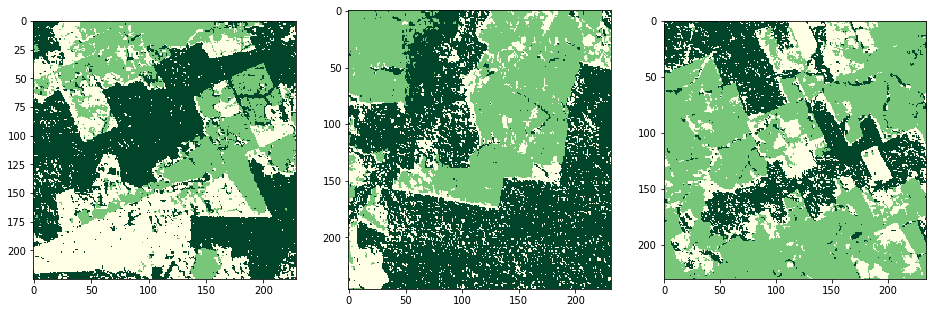

In [392]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot the images
cmap = "YlGn_r"
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1, 3, 1)
plt.imshow(pixels[0])
plt.set_cmap(cmap)
fig.add_subplot(1, 3, 2)
plt.imshow(pixels[1])
plt.set_cmap(cmap)
fig.add_subplot(1, 3, 3)
plt.imshow(pixels[2])
plt.set_cmap(cmap)

| Site 1 Green Band    | Site 2 Green Band | Site 3 Green Band |
| ------------------ | ------------------- | ------------------- |
| ![](pics/brazil3-green.png) | ![](pics/brazil1-green.png)  | ![](pics/brazil2-green.png)

As you can see, the dark green represents forest, with the other two shades representing land that is cleared to some degree. Now let's access more precise statistics about this use.

In [390]:
predRFs[2].select(tileHistogram("prediction")).show(truncate = False)

+-------------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                    |
+-------------------------------------------------------------------------------------------------------------+
|[[54285,-1,0.0,2.0,0.964262687666943,0.4668816360702562],WrappedArray([0.0,13677], [1.0,28871], [2.0,11737])]|
+-------------------------------------------------------------------------------------------------------------+



In [398]:
predRFs[0].select(tileHistogram("prediction")).show(truncate = False)

+-----------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                  |
+-----------------------------------------------------------------------------------------------------------+
|[[51525,-1,0.0,2.0,0.884463852498787,0.73997502792674],WrappedArray([0.0,22384], [1.0,12710], [2.0,16431])]|
+-----------------------------------------------------------------------------------------------------------+



In these examples, a value of zero (Dark Green in the colormap) represents forest. Let's find the percentage of land covered by forest in these examples. Recall that rasters is the list of one dimensional arrays containing all the prediction values for the three scenes.

In [417]:
# Returns the number of cells that we believe the model marked similarly to forest
forest1 = np.count_nonzero(rasters[0] == 0)
forest2 = np.count_nonzero(rasters[1] == 0)
forest3 = np.count_nonzero(rasters[2] == 0)

In [418]:
# Number of forest divided by the total
forest1 / len(rasters[0])

0.43417758369723436

In [416]:
# Total forest cells for all three scenes, divided by total cells
(forest1 + forest2 + forest3) / (len(rasters[0]) + len(rasters[1]) + len(rasters[2]))

0.4001792708832161

In total, it appears that only approximately fourty percent of the area surveyed in these three scenes is forested. While there are improvements to be made, this algorithm could easily be adapted to survey land of any size. Landsat 8 has a temporal resolution of 16 days, and tracking these numbers over time could give an estimate of the rate of change of deforestation in a certain area, or with enough compute power, the entire Amazon Rainforest.